In [11]:
import numpy as np
import tensorflow as tf
import logging
import os
import random
import torch
from abc import ABC, abstractmethod
import time
from sklearn.manifold import TSNE
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import keras 
from keras.datasets import mnist
from keras import backend as k
from torch.utils.data import Subset
import model
import partition
import model2

# Test for second model

import torch
import torchvision
import torch.optim as optim
from  model2 import Net
import training 

In [13]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [15]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [17]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

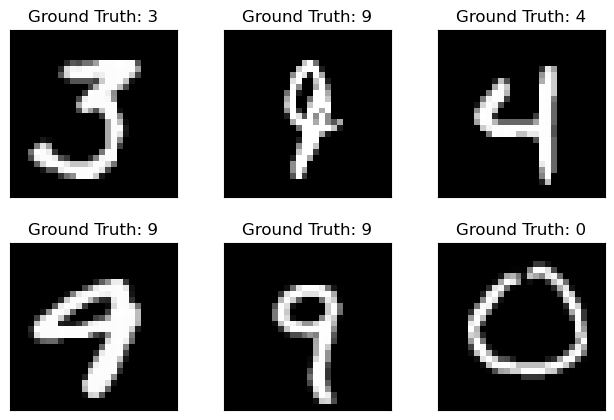

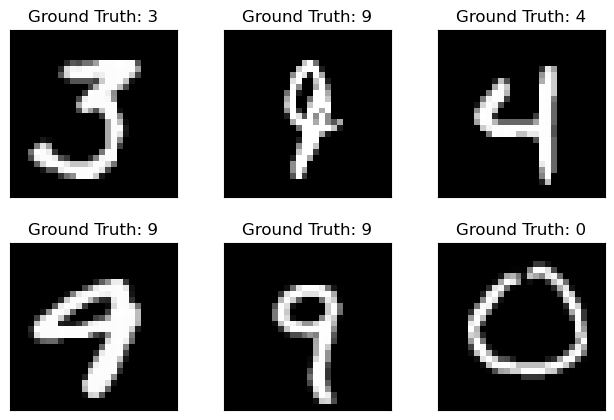

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


In [21]:
network = model2.Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

for epoch in range(1, n_epochs + 1):
  training.train(epoch,network,train_loader,optimizer,log_interval,train_losses,train_counter)
  training.test(network,test_loader,test_losses)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.290954
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.318535
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.261000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259137
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.229576
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.196151
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.181698
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.088444
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.014765
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.818533
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.822772
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.838733
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.530556
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.738141
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.420971
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.369238
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.335397
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.182360
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.056649
Train Epoch: 1 [12800/60000 (

In [22]:
# Data Stuff
# Set download to False if already downloaded
"""""
transform = transforms.Compose([transforms.ToTensor()])

# Load the MNIST dataset 
mnist_trainset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=False, transform=transform)

print(f"Data: {mnist_trainset.data.shape}, Targets: {mnist_trainset.targets.shape}")
"""""
# test data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

img_rows, img_cols=28, 28

if k.image_data_format() == 'channels_first':
   x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
   x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
   inpx = (1, img_rows, img_cols)

else:
   x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
   x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
   inpx = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [25]:
# Check data shapes. later create dataloader or something similar to handle data

print(x_train.shape)
print(y_train.shape)
print(type(y_train))
K = np.unique(y_train)
print(K)
print(inpx)

(60000, 28, 28, 1)
(60000,)
<class 'numpy.ndarray'>
[0 1 2 3 4 5 6 7 8 9]
(28, 28, 1)


In [27]:
# Wrap the data in the MNISTDataset
train_dataset = partition.MNISTDataset(x_train, y_train)

partitioned_data = partition.balanced_dirichlet_partition(train_dataset, partitions_number=10, alpha=0.5, num_clusters=3)

# Access partitions in the first cluster
first_cluster_id = list(partitioned_data.keys())[0]  # Get the first cluster ID
first_cluster_partitions = partitioned_data[first_cluster_id]  # Partitions in the first cluster

# Access the first partition within the first cluster
first_partition_indices = first_cluster_partitions[0]  # List of indices for the first partition

print(first_partition_indices)

# Create a Subset for the first partition
partition_0_dataset = Subset(train_dataset, first_partition_indices)

[10536, 40412, 22752, 12327, 45283, 1876, 49036, 55354, 7820, 3147, 635, 4263, 37724, 56415, 50779, 37913, 32521, 11027, 50472, 23854, 10938, 26188, 52605, 54075, 9930, 56480, 1438, 35496, 10884, 49095, 27604, 38351, 29916, 53923, 57518, 54556, 28768, 27914, 46430, 34215, 14858, 21196, 52417, 53457, 23399, 38731, 46818, 58471, 48753, 44978, 4922, 13386, 57206, 10762, 40832, 27130, 2035, 1265, 38874, 42234, 13368, 44123, 13275, 16456, 3996, 41986, 28035, 56790, 39097, 18042, 35437, 17066, 54749, 38686, 47549, 15115, 57686, 23136, 6116, 23484, 4258, 14291, 35864, 12128, 55010, 48055, 6905, 59529, 13751, 3488, 52747, 43986, 14458, 45782, 45451, 48735, 13913, 7262, 56937, 50678, 10011, 55653, 31387, 50061, 7303, 31294, 1512, 34286, 40377, 21246, 2637, 22185, 42457, 28099, 29064, 55840, 34036, 27101, 32203, 54277, 46621, 43922, 20963, 20263, 9457, 12972, 7371, 35077, 40053, 2663, 35740, 8682, 17474, 23358, 5213, 39844, 34007, 39250, 10983, 27508, 39407, 47174, 53160, 54013, 48410, 19813, 20

In [29]:
"""
# Check sizes
for i in partitioned_data:
    print(len(partitioned_data[i]))
"""

# Reformatting Subsets, loop for all

x_train1, y_train1 = partition.reformat_dataset(partition_0_dataset)

# Check target classes of subclasses
L = np.unique(y_train1)
print(L)

# Convert the labels for model

y_train = keras.utils.to_categorical(y_train)

y_train1 = keras.utils.to_categorical(y_train1)



print(x_train1.shape)
print(y_train1.shape)

x_train shape: (8115, 28, 28, 1)
y_train shape: (8115,)
[0 1 2 3 4 5 6 7 8 9]
(8115, 28, 28, 1)
(8115, 10)
